In [1]:
import pandas as pd
from geopy.geocoders import Nominatim
import sweetviz
from collections import Counter
import numpy as np
from sklearn import preprocessing
import category_encoders as ce
import seaborn as sns
import matplotlib.pyplot as plt 






# Считывание данных


In [2]:
# считываем dataframe  и записываем в переменную
hotels = pd.read_csv('hotels.csv')
display(type(hotels['tags'][0]))

str

In [6]:
# выявляем дубликаты 
# sw = sweetviz.analyze(hotels)
# display(sw.show_html())
dupl = hotels.duplicated()
display(hotels[dupl].shape[0])

307

In [4]:
# удяляем дубликаты из dataframe
hotels = hotels.drop_duplicates()
display(hotels.info())

<class 'pandas.core.frame.DataFrame'>
Index: 386496 entries, 0 to 386802
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               386496 non-null  object 
 1   additional_number_of_scoring                386496 non-null  int64  
 2   review_date                                 386496 non-null  object 
 3   average_score                               386496 non-null  float64
 4   hotel_name                                  386496 non-null  object 
 5   reviewer_nationality                        386496 non-null  object 
 6   negative_review                             386496 non-null  object 
 7   review_total_negative_word_counts           386496 non-null  int64  
 8   total_number_of_reviews                     386496 non-null  int64  
 9   positive_review                             386496 non-null  object 
 10  r

None

In [5]:
# # создаем функцию для удаления неинформативных признаков

# low_informations_cols = []

# for col in hotels.columns:
#     top_freq = hotels[col].value_counts(normalize=True).max()
#     nunique_ratio = hotels[col].nunique() / hotels[col].count()
#     if top_freq > 0.95:
#         low_informations_cols.append(col)
#     if nunique_ratio > 0.95:
#         low_informations_cols.append(col)
# print(low_informations_cols)

# Создание новых признаков в dataframe

In [9]:
# делаем выборку из dataframe  с пропущенными значениями.
hotels_isnull = hotels.loc[(hotels['lat'].isna()) & (hotels['lng'].isna())]


In [10]:
# проверяем результат ячейки
hotel_count = hotels_isnull['hotel_name'].value_counts()
display(hotel_count)

hotel_name
Fleming s Selection Hotel Wien City                 496
Hotel City Central                                  421
Hotel Atlanta                                       285
Maison Albar Hotel Paris Op ra Diamond              224
Hotel Daniel Vienna                                 182
Hotel Pension Baron am Schottentor                  172
Austria Trend Hotel Schloss Wilhelminenberg Wien    141
NH Collection Barcelona Podium                      113
Derag Livinghotel Kaiser Franz Joseph Vienna        112
City Hotel Deutschmeister                            63
Holiday Inn Paris Montmartre                         47
Hotel Park Villa                                     44
Cordial Theaterhotel Wien                            40
Roomz Vienna                                         34
Mercure Paris Gare Montparnasse                      28
Hotel Advance                                        26
Renaissance Barcelona Hotel                          20
Name: count, dtype: int64

In [11]:
# создаем список с названиями отелей
lst = list(hotel_count.index)

In [12]:
# создаем сторонний dataframe для заполнения координат
new_df = pd.DataFrame(index=hotel_count.index,columns=['coordinates'])
new_df.reset_index(inplace=True)
display(new_df.head())


,hotel_name,coordinates
0,Fleming s Selection Hotel Wien City,NaN
1,Hotel City Central,NaN
2,Hotel Atlanta,NaN
3,Maison Albar Hotel Paris Op ra Diamond,NaN
4,Hotel Daniel Vienna,NaN


In [10]:
# создаем функцию для определения координат по названию отеля
def koordinat_lat(data):
        for x in data:
                geolocator = Nominatim(user_agent="Tester")
                location = geolocator.geocode(x) 
                return location.latitude,location.longitude

In [11]:
# заполняем сторонний dataframe координатами
new_df['coordinates'] = new_df['hotel_name'].apply(koordinat_lat)
display(new_df.head(3))

,hotel_name,coordinates
0,Fleming s Selection Hotel Wien City,"(57.535426, 14.641181601671247)"
1,Hotel City Central,"(50.6080651, 9.0284647)"
2,Hotel Atlanta,"(50.6080651, 9.0284647)"


In [12]:
# создаем функцию которая из стороннего dataframe извлекаем название отеля и координаты в словарь
def coordinates_add():
    sl ={}
    lst = [x for x in new_df['coordinates']]
    for x,y in enumerate(new_df['hotel_name']):
        sl[y] = lst[x]
    return sl

In [13]:
# присваеваем результат функции переменной
res = coordinates_add() 
print(res)      

{'Fleming s Selection Hotel Wien City': (57.535426, 14.641181601671247), 'Hotel City Central': (50.6080651, 9.0284647), 'Hotel Atlanta': (50.6080651, 9.0284647), 'Maison Albar Hotel Paris Op ra Diamond': (2.3293744, 102.2880962), 'Hotel Daniel Vienna': (50.6080651, 9.0284647), 'Hotel Pension Baron am Schottentor': (50.6080651, 9.0284647), 'Austria Trend Hotel Schloss Wilhelminenberg Wien': (22.6672576, 114.0319442), 'NH Collection Barcelona Podium': (8.7712794, 13.7803627), 'Derag Livinghotel Kaiser Franz Joseph Vienna': (30.4908442, -86.550624), 'City Hotel Deutschmeister': (22.6662626, 114.0309545), 'Holiday Inn Paris Montmartre': (50.6080651, 9.0284647), 'Hotel Park Villa': (50.6080651, 9.0284647), 'Cordial Theaterhotel Wien': (52.3148564, 4.7432257), 'Roomz Vienna': (-22.9110137, -43.2093727), 'Mercure Paris Gare Montparnasse': (2.3293744, 102.2880962), 'Hotel Advance': (50.6080651, 9.0284647), 'Renaissance Barcelona Hotel': (-22.9110137, -43.2093727)}


In [14]:
# создаем функцию которая заполняет пропуски в исходном dataframe значениями из словаря 
def update_lat_lmg(row):
    if pd.isna(row.lat) or pd.isna(row.lng):
        row.lat = res[row.hotel_name][0]
        row.lng = res[row.hotel_name][1]
    return row


In [15]:
# применяем функцию к dataframe
hotels_drop = hotels.apply(lambda row: update_lat_lmg(row),axis=1)
display(hotels_drop.info())

<class 'pandas.core.frame.DataFrame'>
Index: 386496 entries, 0 to 386802
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               386496 non-null  object 
 1   additional_number_of_scoring                386496 non-null  int64  
 2   review_date                                 386496 non-null  object 
 3   average_score                               386496 non-null  float64
 4   hotel_name                                  386496 non-null  object 
 5   reviewer_nationality                        386496 non-null  object 
 6   negative_review                             386496 non-null  object 
 7   review_total_negative_word_counts           386496 non-null  int64  
 8   total_number_of_reviews                     386496 non-null  int64  
 9   positive_review                             386496 non-null  object 
 10  r

None

In [16]:
# преобразовываем признак с датой в тип datetime
hotels['review_date'] = pd.to_datetime(hotels['review_date'])


In [17]:
# выполняем задание на платформе
res = Counter()

for x in hotels['tags']:
    x= x.replace(']','').replace('[','').replace("'",'').split(',')
    for elem in x:
        res[elem.strip()] += 1
        
print(res.most_common(5))

[('Leisure trip', 313353), ('Submitted from a mobile device', 230608), ('Couple', 189046), ('Stayed 1 night', 145296), ('Stayed 2 nights', 100176)]


In [3]:
display(hotels.head(30))

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,lat,lng
0,Stratton Street Mayfair Westminster Borough Lo...,581,2/19/2016,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,4,7,10.0,"[' Leisure trip ', ' Couple ', ' Studio Suite ...",531 day,51.507894,-0.143671
1,130 134 Southampton Row Camden London WC1B 5AF...,299,1/12/2017,8.3,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,2,14,6.3,"[' Business trip ', ' Couple ', ' Standard Dou...",203 day,51.521009,-0.123097
2,151 bis Rue de Rennes 6th arr 75006 Paris France,32,10/18/2016,8.9,Legend Saint Germain by Elegancia,China,No kettle in room,6,406,No Positive,0,14,7.5,"[' Leisure trip ', ' Solo traveler ', ' Modern...",289 day,48.845377,2.325643
3,216 Avenue Jean Jaures 19th arr 75019 Paris Fr...,34,9/22/2015,7.5,Mercure Paris 19 Philharmonie La Villette,United Kingdom,No Negative,0,607,Friendly staff quiet comfortable room spotles...,11,8,10.0,"[' Leisure trip ', ' Solo traveler ', ' Standa...",681 day,48.888697,2.394540
4,Molenwerf 1 1014 AG Amsterdam Netherlands,914,3/5/2016,8.5,Golden Tulip Amsterdam West,Poland,Torn sheets,4,7586,The staff was very friendly and helpful Break...,20,10,9.6,"[' Business trip ', ' Couple ', ' Standard Dou...",516 day,52.385601,4.847060
5,Via Mecenate 121 20138 Milan Italy,105,12/30/2015,8.0,Novotel Milano Linate Aeroporto,France,Nothing,2,1607,Very nice hotel Price is excellent when compa...,16,1,10.0,"[' Business trip ', ' Solo traveler ', ' Super...",582 day,45.448188,9.257046
6,97 Cromwell Road Kensington and Chelsea London...,854,5/18/2017,7.8,Holiday Inn London Kensington Forum,United Kingdom,Nothing it was lovely,6,3867,Very central location 2 minutes walk from Glo...,29,4,9.6,"[' Leisure trip ', ' Couple ', ' Double Room N...",77 days,51.494231,-0.185114
7,Josefsgasse 4 6 08 Josefstadt 1080 Vienna Austria,227,1/23/2017,8.3,Mercure Josefshof Wien,United Kingdom,The communal areas are a bit soul less and th...,40,2526,The location is good for transport links espe...,107,39,8.3,"[' Leisure trip ', ' Couple ', ' Superior Doub...",192 day,48.208563,16.354169
8,190 Queen s Gate Kensington and Chelsea London...,227,11/24/2015,8.6,The Gore Hotel Starhotels Collezione,United Kingdom,undergoing refurbishment no tea coffer in roo...,30,968,staff very good location wonderful,7,3,8.3,"[' Leisure trip ', ' Couple ', ' Double Room '...",618 day,51.500198,-0.179536
9,Holland Park Avenue Kensington and Chelsea Lon...,843,2/2/2016,7.8,Hilton London Kensington Hotel,United Kingdom,I advised it was for my husbands birthday and...,47,3801,No Positive,0,1,6.7,"[' Leisure trip ', ' Couple ', ' Twin Hilton G...",548 day,51.505108,-0.213266


In [19]:
# создаем функцию для  преобразования длинны значений в признаке tags
def tags_update(strong):
    strong = strong.replace(']','').replace('[','').replace("'",'').split(',')
    lst = list()
    for x in strong:
        lst.append(x.strip())
    while len(lst) < 5:
        lst.append('unknown')     
    return lst

In [20]:
# применяем функцию к признаку tags
hotels['tags'] = hotels['tags'].apply(tags_update)

In [21]:
# проверяем результат
display(hotels['tags'].tail(7).values)
display(hotels['tags'].iloc[::9].values)

array([list(['Leisure trip', 'Couple', 'Standard Double Room', 'Stayed 1 night', 'Submitted from a mobile device']),
       list(['Leisure trip', 'Group', 'Standard Queen Room', 'Stayed 3 nights', 'unknown']),
       list(['Leisure trip', 'Group', 'Club Double or Twin Room', 'Stayed 2 nights', 'Submitted from a mobile device']),
       list(['Leisure trip', 'Couple', 'Standard Double Room', 'Stayed 4 nights', 'Submitted from a mobile device']),
       list(['Business trip', 'Solo traveler', 'Single Room', 'Stayed 1 night', 'unknown']),
       list(['Leisure trip', 'Solo traveler', 'Deluxe Double Room', 'Stayed 2 nights', 'unknown']),
       list(['Leisure trip', 'Couple', 'Bunk Bed Room', 'Stayed 4 nights', 'unknown'])],
      dtype=object)

array([list(['Leisure trip', 'Couple', 'Studio Suite', 'Stayed 2 nights', 'Submitted from a mobile device']),
       list(['Leisure trip', 'Couple', 'Twin Hilton Guest Room', 'Stayed 1 night', 'Submitted from a mobile device']),
       list(['Leisure trip', 'Solo traveler', 'Standard Double Room', 'Stayed 2 nights', 'unknown']),
       ...,
       list(['Leisure trip', 'Couple', 'One Bedroom Suite', 'Stayed 1 night', 'Submitted from a mobile device']),
       list(['Leisure trip', 'Couple', 'Classic Double Room', 'Stayed 6 nights', 'Submitted from a mobile device']),
       list(['Leisure trip', 'Solo traveler', 'Luxury Room 1 Queensize Bed Twin bedded Room On Request', 'Stayed 6 nights', 'Submitted from a mobile device'])],
      dtype=object)

In [22]:
display(hotels['tags'][0][0])

'Leisure trip'

In [23]:
# создаем признак вид поездки
hotels['trip'] = hotels['tags'].apply(lambda x : x[0] if 'trip' in x[0]  else 'unknown') 
display(hotels['trip'])

0          Leisure trip
1         Business trip
2          Leisure trip
3          Leisure trip
4         Business trip
              ...      
386798     Leisure trip
386799     Leisure trip
386800    Business trip
386801     Leisure trip
386802     Leisure trip
Name: trip, Length: 386496, dtype: object

In [24]:
# создаем признак кол-во человек
hotels['count_people'] = hotels['tags'].apply(lambda x : x[1] if 'Couple' in x[1] or 'Group' in x[1] or 'traveler' in x[1] else 'unknown')

In [25]:
# создаем признак кол-во комнат
hotels['hotel_room'] = hotels['tags'].apply(lambda x: x[2] if 'Room' in x[2] or 'rooms' in x[2] or 'Junior' in x[2] else 'unknown')
display(hotels['hotel_room'])

0                                 unknown
1                    Standard Double Room
2                 Modern Double Room Echo
3         Standard Room with 1 Double Bed
4            Standard Double or Twin Room
                       ...               
386798           Club Double or Twin Room
386799               Standard Double Room
386800                        Single Room
386801                 Deluxe Double Room
386802                      Bunk Bed Room
Name: hotel_room, Length: 386496, dtype: object

In [26]:
# создаем признак кол-во ночей
hotels['count_night'] = hotels['tags'].apply(lambda x : x[3] if 'nights' in x[3] or 'night' in x[3] else 0)

In [27]:
# применяем регулярное выражение для отоброжения числа из строки 
hotels['count_night'] = hotels['count_night'].str.findall('\d+')

In [28]:
hotels['count_night'] = hotels['count_night'][:].apply(lambda x: str(x)[:].replace("]", "").replace("[", '').replace("'",''))

In [29]:
hotels['count_night'] = hotels['count_night'].replace({'nan':0})

In [30]:
# меняем тип признака на int
hotels['count_night'] = hotels['count_night'].astype('int')

In [31]:
# создаем признак способ отправки и кодируем его
hotels['sending method'] = hotels['tags'].apply(lambda x : x[4] if 'Submitted from a mobile device' in x[4] else 'unknown') 
hotels['sending method'] = hotels['sending method'].replace({'Submitted from a mobile device':1, 'unknown':0})
hotels['sending method']

0         1
1         0
2         1
3         0
4         0
         ..
386798    1
386799    1
386800    0
386801    0
386802    0
Name: sending method, Length: 386496, dtype: int64

In [32]:
hotels['negative_review'].value_counts()

negative_review
No Negative                                                                                                                                                        95833
 Nothing                                                                                                                                                           10733
 Nothing                                                                                                                                                            3152
 nothing                                                                                                                                                            1658
 N A                                                                                                                                                                 802
                                                                                                                                           

In [33]:
# создаем признак негатвный отзыв и удаляем пробелы с двух сторон у значений признака
hotels['negative_review'] = hotels['negative_review'].apply(lambda x: x.strip())
hotels['negative_review'].value_counts()

negative_review
No Negative                                                                                                                                                               95833
Nothing                                                                                                                                                                   13885
nothing                                                                                                                                                                    1877
None                                                                                                                                                                        871
N A                                                                                                                                                                         818
                                                                                                        

In [34]:
display(hotels.head(3))

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,...,reviewer_score,tags,days_since_review,lat,lng,trip,count_people,hotel_room,count_night,sending method
0,Stratton Street Mayfair Westminster Borough Lo...,581,2016-02-19,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,...,10.0,"[Leisure trip, Couple, Studio Suite, Stayed 2 ...",531 day,51.507894,-0.143671,Leisure trip,Couple,unknown,2,1
1,130 134 Southampton Row Camden London WC1B 5AF...,299,2017-01-12,8.3,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,...,6.3,"[Business trip, Couple, Standard Double Room, ...",203 day,51.521009,-0.123097,Business trip,Couple,Standard Double Room,1,0
2,151 bis Rue de Rennes 6th arr 75006 Paris France,32,2016-10-18,8.9,Legend Saint Germain by Elegancia,China,No kettle in room,6,406,No Positive,...,7.5,"[Leisure trip, Solo traveler, Modern Double Ro...",289 day,48.845377,2.325643,Leisure trip,Solo traveler,Modern Double Room Echo,3,1


In [35]:
# создаем признак день
hotels['day'] = hotels['review_date'].dt.day

In [36]:
# создаем признак месяц
hotels['month'] = hotels['review_date'].dt.month

In [37]:
# создаем признак год
hotels['year'] = hotels['review_date'].dt.year

In [38]:
# преобразовываем признак количество дней между датой проверки и датой очистки 
hotels['days_since_review'] = hotels['days_since_review'].astype('object')
hotels['days_since_review'] = hotels['days_since_review'].str.findall('\d+')
hotels['days_since_review'] = hotels['days_since_review'].apply(lambda x: x[0])
hotels['days_since_review'] = hotels['days_since_review'].astype('int')
display(hotels['days_since_review'])



0         531
1         203
2         289
3         681
4         516
         ... 
386798    106
386799    171
386800    543
386801     74
386802    363
Name: days_since_review, Length: 386496, dtype: int32

In [39]:
# создаем признак страна отеля
hotels['hotel_country'] = hotels['hotel_address'].apply(lambda x : x.split(' ')[-1])

In [40]:
# создаем признак город отеля
hotels['hotel_city'] = hotels['hotel_address'].apply(lambda x : x.split(' ')[-2])

In [41]:
hotels['hotel_city']

0            United
1            United
2             Paris
3             Paris
4         Amsterdam
            ...    
386798       United
386799       Vienna
386800       United
386801       United
386802       United
Name: hotel_city, Length: 386496, dtype: object

In [42]:
hotels.dtypes

hotel_address                                         object
additional_number_of_scoring                           int64
review_date                                   datetime64[ns]
average_score                                        float64
hotel_name                                            object
reviewer_nationality                                  object
negative_review                                       object
review_total_negative_word_counts                      int64
total_number_of_reviews                                int64
positive_review                                       object
review_total_positive_word_counts                      int64
total_number_of_reviews_reviewer_has_given             int64
reviewer_score                                       float64
tags                                                  object
days_since_review                                      int32
lat                                                  float64
lng                     

In [43]:
# создаем функцию для кодировки положительных отзывов
def positive_func(row):
    if 'No Positive' in row:
        return 0
    elif 'Location' in row or 'location' in row:
        return 1
    elif 'Everything' in row:
        return 2
    elif 'Nothing' in row:
        return 3
    else:
        return 4

In [44]:
# кодируем признак положительный отзыв
hotels['positive_review'] = hotels['positive_review'].apply(positive_func)

In [45]:
hotels['negative_review'].value_counts()

negative_review
No Negative                                                                                                                                                               95833
Nothing                                                                                                                                                                   13885
nothing                                                                                                                                                                    1877
None                                                                                                                                                                        871
N A                                                                                                                                                                         818
                                                                                                        

In [46]:
# создаем функцию для кодировки признака негативные отзывы
def negative_func(row):
    if 'No Negative' in row:
        return 0
    elif 'Nothing' in row or 'nothing' in row:
        return 1
    elif 'None' in row or 'N A' in row:
        return 2
    else:
        return 3

In [47]:
# кодируем признак негативные отзывы
hotels['negative_review'] = hotels['negative_review'].apply(negative_func)

In [48]:
hotels['negative_review'].value_counts()

negative_review
3    260084
0     95836
1     28597
2      1979
Name: count, dtype: int64

In [49]:
# удаляем столбцы со строковым типом данных
hotels.drop(['hotel_address','review_date','tags'],axis=1,inplace=True)

In [50]:
hotels['year'].value_counts()

year
2016    198071
2017    117574
2015     70851
Name: count, dtype: int64

In [51]:
# кодируем признаки в которых меньше 15 значений
coder = ce.OneHotEncoder(cols=['trip','count_people','hotel_country','hotel_city'])
fit = coder.fit_transform(hotels[['trip','count_people','hotel_country','hotel_city']])
hotels = pd.concat([hotels,fit],axis=1)

In [52]:
# кодируем признаки в которых больше 15 значений
coder = ce.BinaryEncoder(cols=['hotel_name','reviewer_nationality','hotel_room'])
fit = coder.fit_transform(hotels[['hotel_name','reviewer_nationality','hotel_room']])
hotels = pd.concat([hotels,fit],axis=1)

In [53]:
# удаляем признаки со строковыми значениями после кодировки
hotels.drop(['trip','count_people','hotel_country','hotel_city','hotel_name','reviewer_nationality','hotel_room'],axis=1 , inplace=True)

In [54]:
# создаем dataframe c числовыми признаками
hotels_digit = hotels[['additional_number_of_scoring', 'average_score','review_total_negative_word_counts', 'total_number_of_reviews','total_number_of_reviews_reviewer_has_given', 'reviewer_score',
                       'days_since_review','count_night','review_total_positive_word_counts']]

# Визуализация зависимости признаков друг от друга

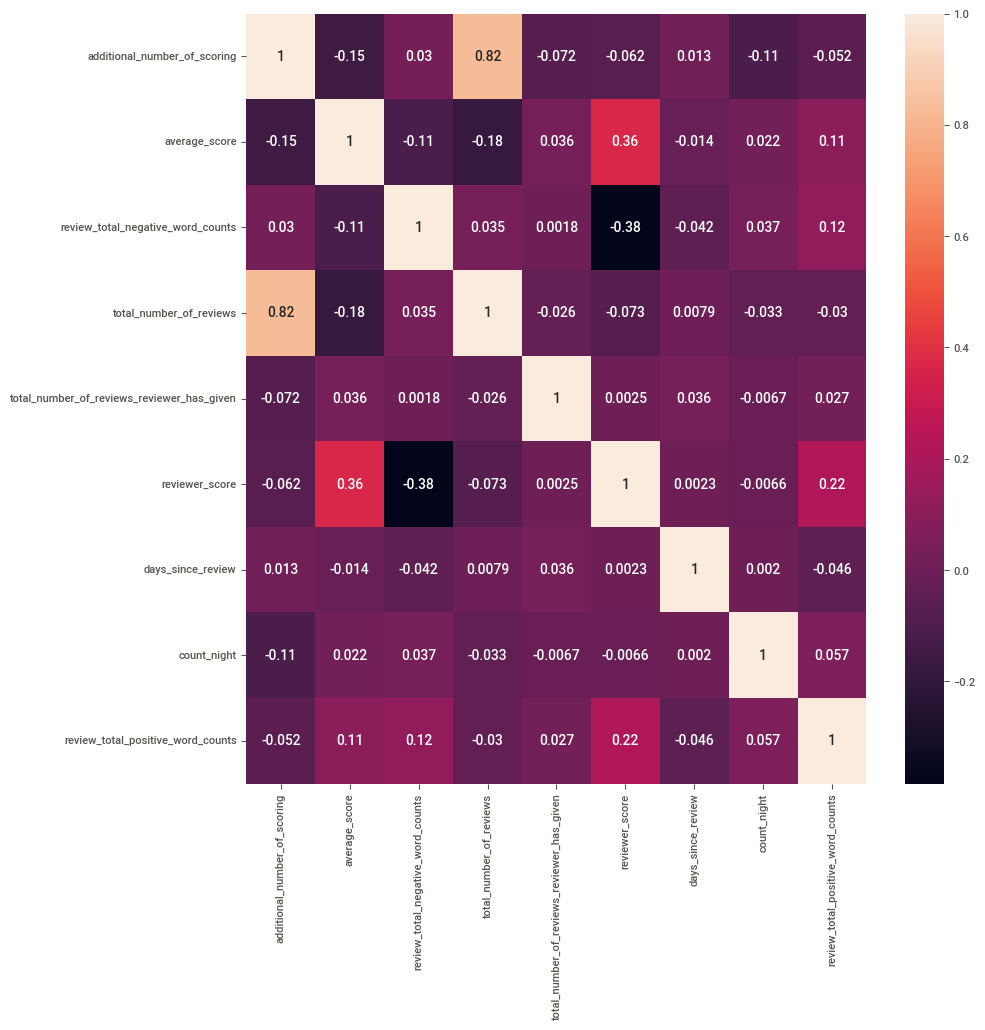

In [55]:
# создаем тепловую карту корреляции числовых признаков
fig = plt.figure(figsize=(10,10))
fig = sns.heatmap(hotels_digit.corr(method='pearson'),annot=True)


In [56]:
# удаляем признак с мультикорелярностью
hotels.drop('additional_number_of_scoring',axis=1,inplace=True)

In [57]:
hotels.columns

Index(['average_score', 'negative_review', 'review_total_negative_word_counts',
       'total_number_of_reviews', 'positive_review',
       'review_total_positive_word_counts',
       'total_number_of_reviews_reviewer_has_given', 'reviewer_score',
       'days_since_review', 'lat', 'lng', 'count_night', 'sending method',
       'day', 'month', 'year', 'trip_1', 'trip_2', 'trip_3', 'count_people_1',
       'count_people_2', 'count_people_3', 'count_people_4', 'hotel_country_1',
       'hotel_country_2', 'hotel_country_3', 'hotel_country_4',
       'hotel_country_5', 'hotel_country_6', 'hotel_city_1', 'hotel_city_2',
       'hotel_city_3', 'hotel_city_4', 'hotel_city_5', 'hotel_city_6',
       'hotel_name_0', 'hotel_name_1', 'hotel_name_2', 'hotel_name_3',
       'hotel_name_4', 'hotel_name_5', 'hotel_name_6', 'hotel_name_7',
       'hotel_name_8', 'hotel_name_9', 'hotel_name_10',
       'reviewer_nationality_0', 'reviewer_nationality_1',
       'reviewer_nationality_2', 'reviewer_nation

In [58]:
# создаем dataframe с категориальными признаками 
hotels_category  = hotels[['days_since_review', 'lat', 'lng', 'count_night', 'sending method',
       'day', 'month', 'year', 'trip_1', 'trip_2', 'trip_3', 'count_people_1',
       'count_people_2', 'count_people_3', 'count_people_4', 'hotel_country_1',
       'hotel_country_2', 'hotel_country_3', 'hotel_country_4',
       'hotel_country_5', 'hotel_country_6', 'hotel_city_1', 'hotel_city_2',
       'hotel_city_3', 'hotel_city_4', 'hotel_city_5', 'hotel_city_6',
       'hotel_name_0', 'hotel_name_1', 'hotel_name_2', 'hotel_name_3',
       'hotel_name_4', 'hotel_name_5', 'hotel_name_6', 'hotel_name_7',
       'hotel_name_8', 'hotel_name_9', 'hotel_name_10',
       'reviewer_nationality_0', 'reviewer_nationality_1',
       'reviewer_nationality_2', 'reviewer_nationality_3',
       'reviewer_nationality_4', 'reviewer_nationality_5',
       'reviewer_nationality_6', 'reviewer_nationality_7', 'hotel_room_0',
       'hotel_room_1', 'hotel_room_2', 'hotel_room_3', 'hotel_room_4',
       'hotel_room_5', 'hotel_room_6', 'hotel_room_7', 'hotel_room_8',
       'hotel_room_9', 'hotel_room_10','negative_review','positive_review']]

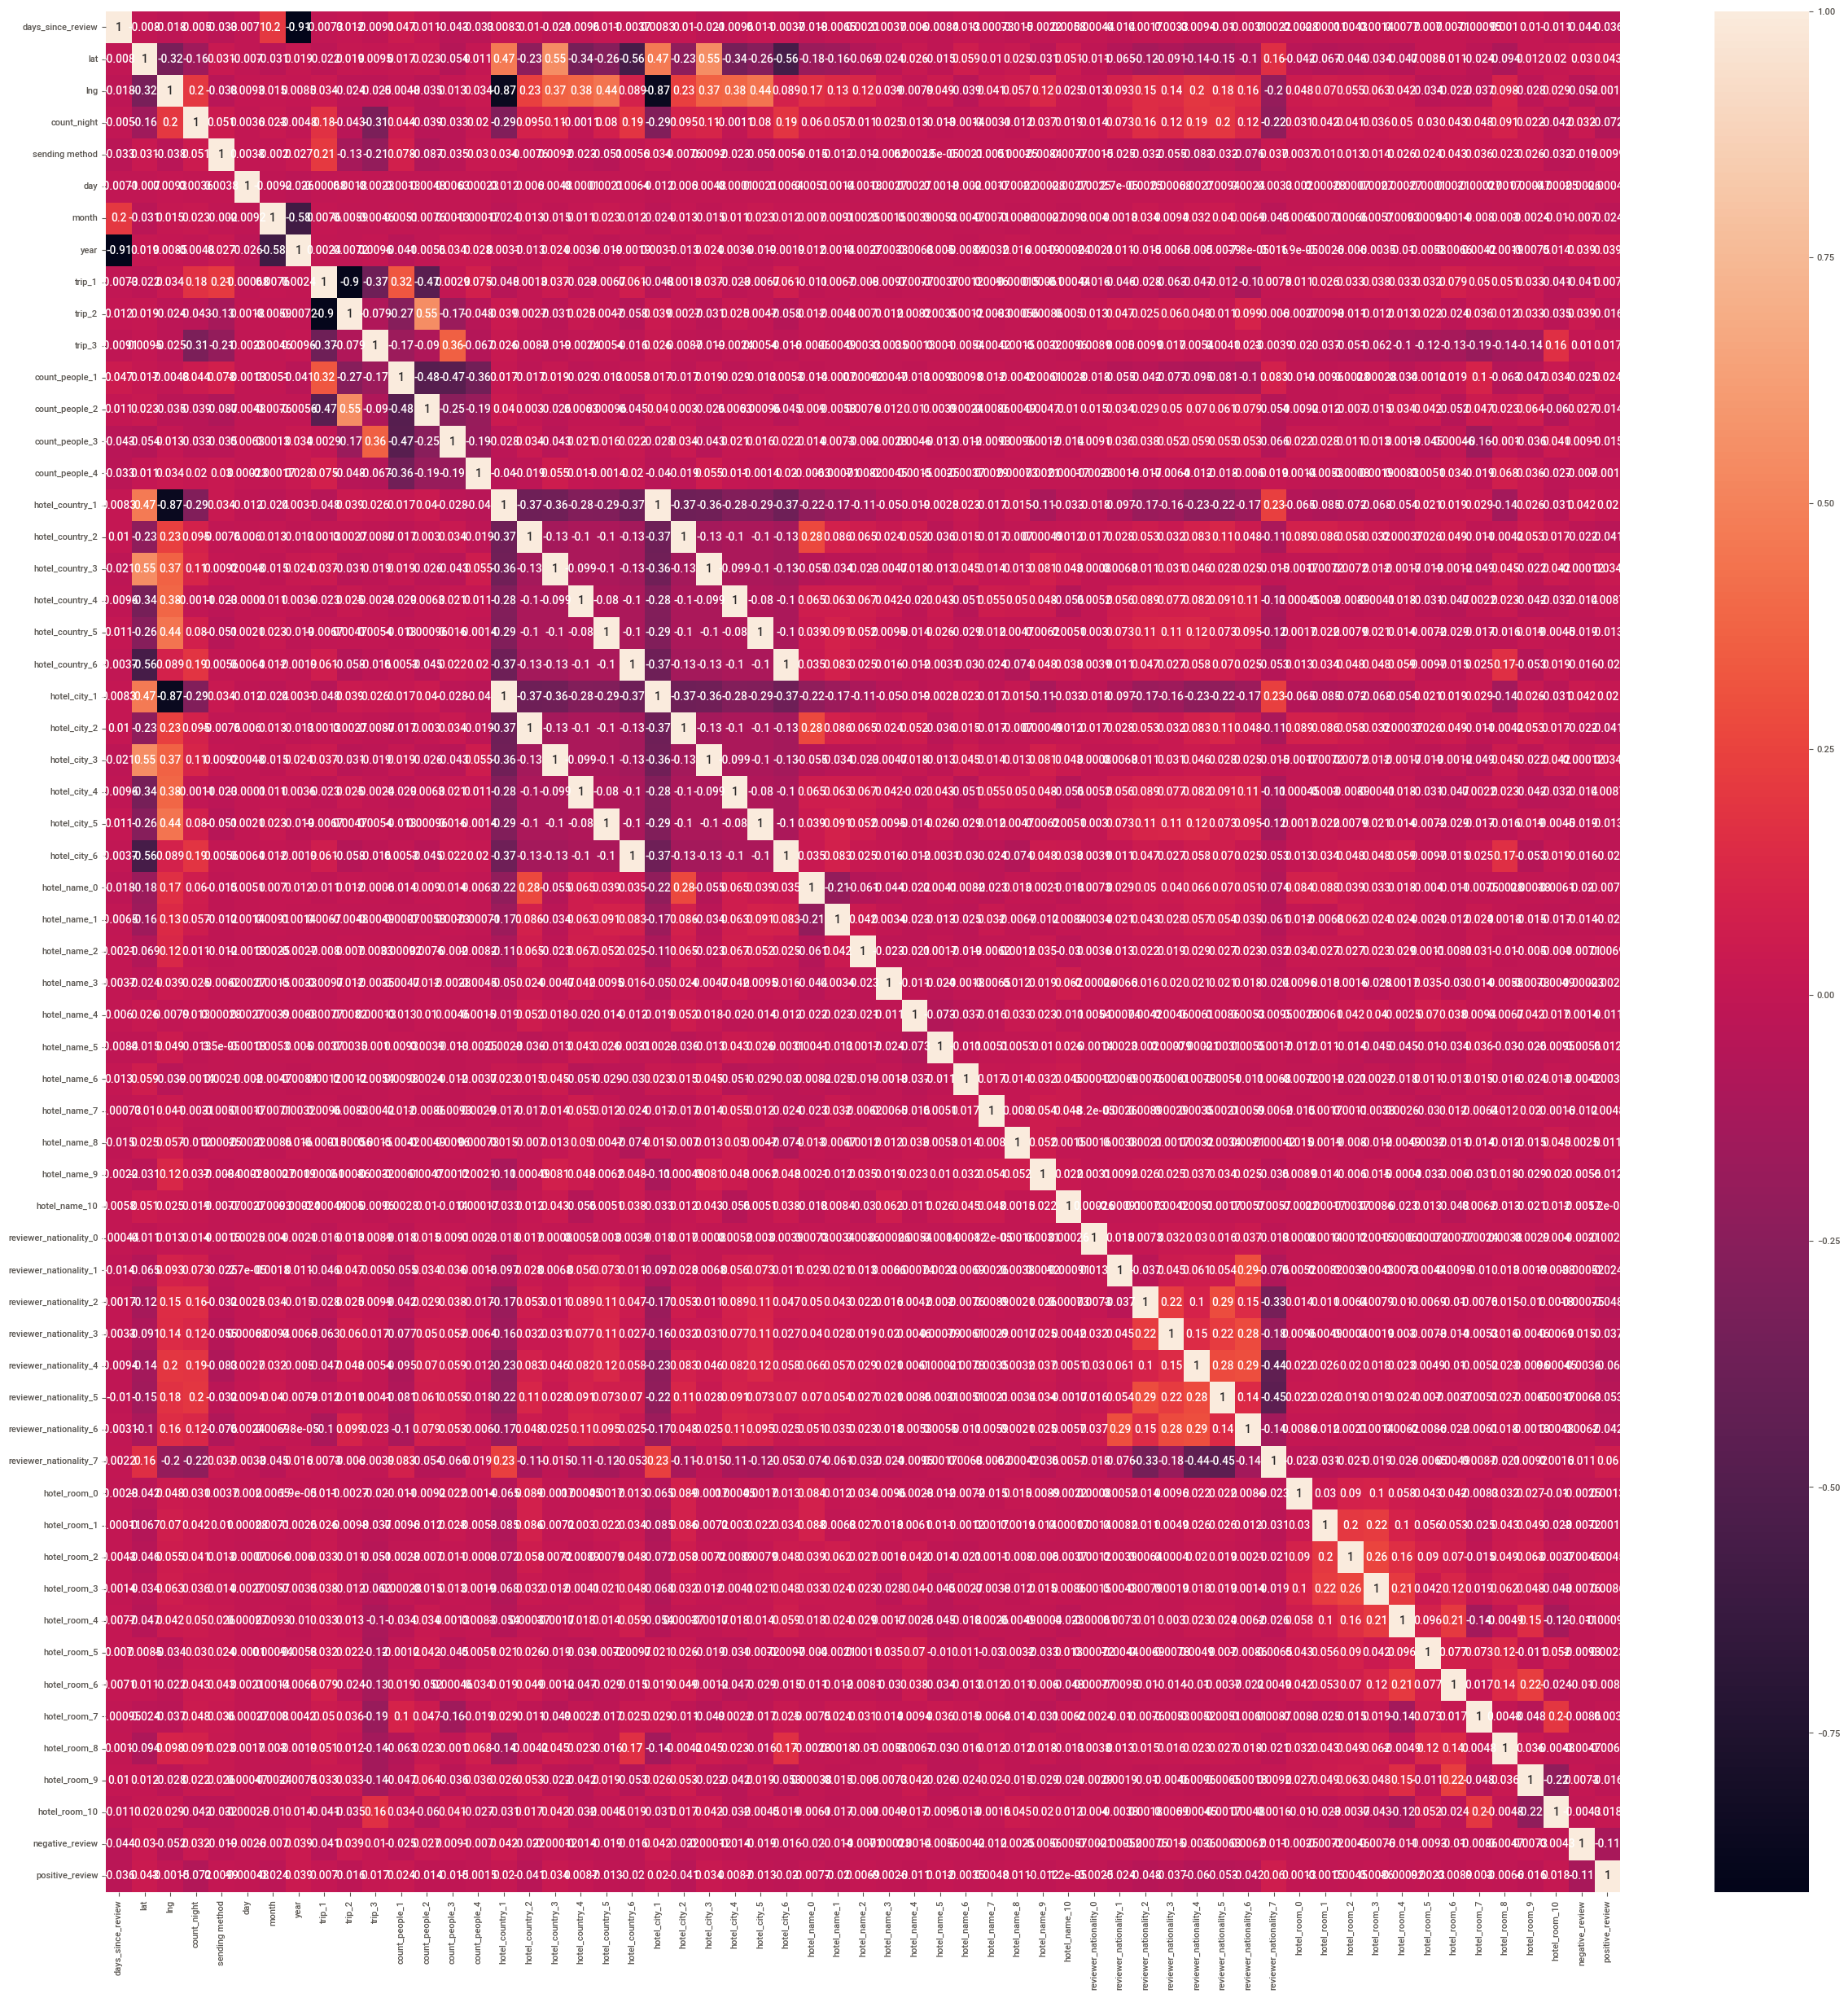

In [59]:
# создаем тепловую карту корреляции категориальных признаков
fig = plt.figure(figsize=(30,30))
fig = sns.heatmap(hotels_category.corr(method='spearman'),annot=True)

In [60]:
# удаляем признак с мультикорелярностью
hotels.drop(['year','hotel_country_1','hotel_city_1','trip_1','trip_2','lat','lng'],axis=1, inplace=True)

In [61]:
hotels.columns

Index(['average_score', 'negative_review', 'review_total_negative_word_counts',
       'total_number_of_reviews', 'positive_review',
       'review_total_positive_word_counts',
       'total_number_of_reviews_reviewer_has_given', 'reviewer_score',
       'days_since_review', 'count_night', 'sending method', 'day', 'month',
       'trip_3', 'count_people_1', 'count_people_2', 'count_people_3',
       'count_people_4', 'hotel_country_2', 'hotel_country_3',
       'hotel_country_4', 'hotel_country_5', 'hotel_country_6', 'hotel_city_2',
       'hotel_city_3', 'hotel_city_4', 'hotel_city_5', 'hotel_city_6',
       'hotel_name_0', 'hotel_name_1', 'hotel_name_2', 'hotel_name_3',
       'hotel_name_4', 'hotel_name_5', 'hotel_name_6', 'hotel_name_7',
       'hotel_name_8', 'hotel_name_9', 'hotel_name_10',
       'reviewer_nationality_0', 'reviewer_nationality_1',
       'reviewer_nationality_2', 'reviewer_nationality_3',
       'reviewer_nationality_4', 'reviewer_nationality_5',
       'reviewe

In [62]:
# числовые признаки
num_cols = ['average_score','review_total_negative_word_counts','total_number_of_reviews',
            'review_total_positive_word_counts',
            'total_number_of_reviews_reviewer_has_given',
              'days_since_review']

# категориальные признаки
cat_cols = [ 'count_night', 'sending method',
       'day', 'month', 'trip_3', 'count_people_1', 'count_people_2',
       'count_people_3', 'count_people_4', 'hotel_country_2',
       'hotel_country_3', 'hotel_country_4', 'hotel_country_5',
       'hotel_country_6', 'hotel_city_2', 'hotel_city_3', 'hotel_city_4',
       'hotel_city_5', 'hotel_city_6', 'hotel_name_0', 'hotel_name_1',
       'hotel_name_2', 'hotel_name_3', 'hotel_name_4', 'hotel_name_5',
       'hotel_name_6', 'hotel_name_7', 'hotel_name_8', 'hotel_name_9',
       'hotel_name_10', 'reviewer_nationality_0', 'reviewer_nationality_1',
       'reviewer_nationality_2', 'reviewer_nationality_3',
       'reviewer_nationality_4', 'reviewer_nationality_5',
       'reviewer_nationality_6', 'reviewer_nationality_7', 'hotel_room_0',
       'hotel_room_1', 'hotel_room_2', 'hotel_room_3', 'hotel_room_4',
       'hotel_room_5', 'hotel_room_6', 'hotel_room_7', 'hotel_room_8',
       'hotel_room_9', 'hotel_room_10']

# Создаем модель

In [63]:
# Разбиваем датафрейм на части, необходимые для обучения и тестирования модели  
# Х - данные с информацией об отелях, у - целевая переменная (рейтинги отелей)  
X = hotels.drop(['reviewer_score'], axis = 1)  
y = hotels['reviewer_score'] 

In [64]:
# Загружаем специальный инструмент для разбивки:  
from sklearn.model_selection import train_test_split  

In [65]:
# Наборы данных с меткой "train" будут использоваться для обучения модели, "test" - для тестирования.  
# Для тестирования мы будем использовать 25% от исходного датасета.  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

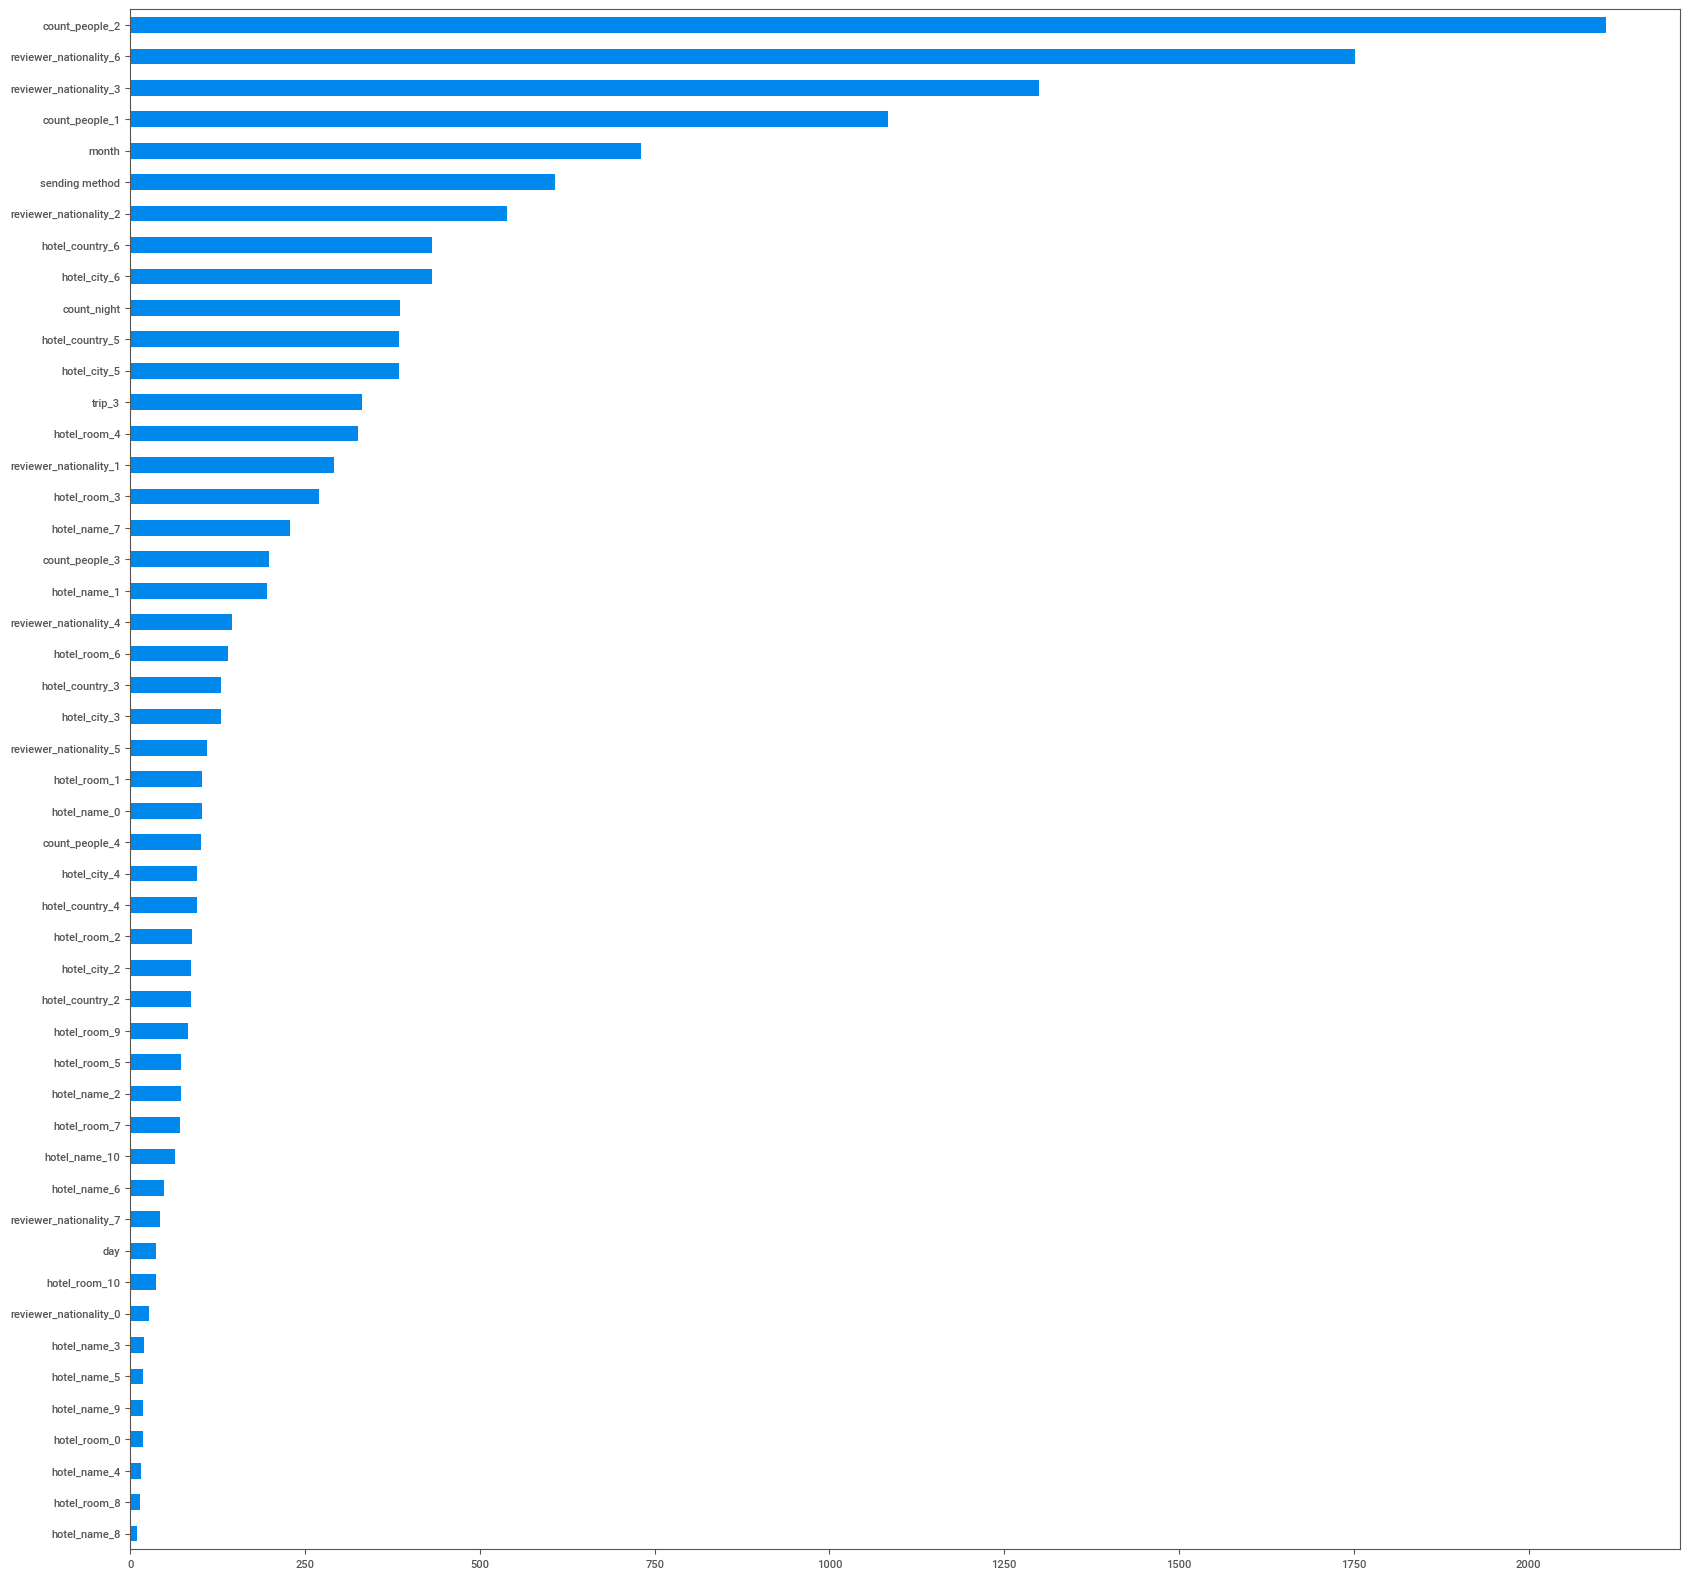

In [66]:
# применяем тест хи-квадрат для категориальных признаков и визуализируем его
y=y.astype('int')

from sklearn.feature_selection import chi2 # хи-квадрат

imp_cat = pd.Series(chi2(X[cat_cols], y)[0], index=cat_cols)
imp_cat.sort_values(inplace = True)
fig  = plt.figure(figsize=(20,20))
fig = imp_cat.plot(kind = 'barh')

<Axes: >

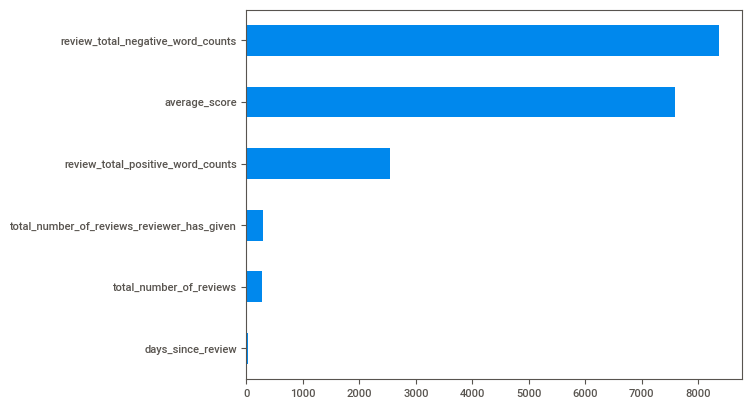

In [67]:
# применяем тест anova для числовых признаков и визуализируем его
from sklearn.feature_selection import f_classif # anova

imp_num = pd.Series(f_classif(X[num_cols], y)[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

In [68]:
# удаляем из тестовой и тренировочной выборок менее информативные признаки
X_test.drop( [
       'day',
       'count_people_3', 'count_people_4', 'hotel_country_2',
       'hotel_country_3', 'hotel_country_4', 'hotel_country_5',
       'hotel_country_6', 'hotel_city_2', 'hotel_city_3', 'hotel_city_4',
       'hotel_city_5', 'hotel_name_0', 'hotel_name_1',
       'hotel_name_2', 'hotel_name_3', 'hotel_name_4', 'hotel_name_5',
       'hotel_name_6', 'hotel_name_7', 'hotel_name_8', 'hotel_name_9',
       'hotel_name_10', 'reviewer_nationality_0', 'reviewer_nationality_1',
       'reviewer_nationality_2',
       'reviewer_nationality_4', 'reviewer_nationality_5',
       'reviewer_nationality_7', 'hotel_room_0',
       'hotel_room_1', 'hotel_room_2', 'hotel_room_3',
       'hotel_room_5', 'hotel_room_6', 'hotel_room_7', 'hotel_room_8',
       'hotel_room_9', 'hotel_room_10','days_since_review'],axis=1,inplace=True)
X_train.drop([
       'day',
       'count_people_3', 'count_people_4', 'hotel_country_2',
       'hotel_country_3', 'hotel_country_4', 'hotel_country_5',
       'hotel_country_6', 'hotel_city_2', 'hotel_city_3', 'hotel_city_4',
       'hotel_city_5', 'hotel_name_0', 'hotel_name_1',
       'hotel_name_2', 'hotel_name_3', 'hotel_name_4', 'hotel_name_5',
       'hotel_name_6', 'hotel_name_7', 'hotel_name_8', 'hotel_name_9',
       'hotel_name_10', 'reviewer_nationality_0', 'reviewer_nationality_1',
       'reviewer_nationality_2',
       'reviewer_nationality_4', 'reviewer_nationality_5',
       'reviewer_nationality_7', 'hotel_room_0',
       'hotel_room_1', 'hotel_room_2', 'hotel_room_3',
       'hotel_room_5', 'hotel_room_6', 'hotel_room_7', 'hotel_room_8',
       'hotel_room_9', 'hotel_room_10','days_since_review'],axis=1,inplace=True)


In [69]:
# Импортируем необходимые библиотеки:  
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели  
from sklearn import metrics # инструменты для оценки точности модели  
  
# Создаём модель  
regr = RandomForestRegressor(n_estimators=100)  
      
# Обучаем модель на тестовом наборе данных  
regr.fit(X_train, y_train)  
      
# Используем обученную модель для предсказания рейтинга отелей в тестовой выборке.  
# Предсказанные значения записываем в переменную y_pred  
y_pred = regr.predict(X_test)  


In [70]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они отличаются  
# Метрика называется Mean Absolute Percentage Error (MAPE) и показывает среднюю абсолютную процентную ошибку предсказанных значений от фактических.  
print('MAPE:', metrics.mean_absolute_percentage_error(y_test, y_pred))

MAPE: 0.13391369681226584


Небольшой бонус:


In [71]:
# # убираем признаки которые еще не успели обработать, 
# # модель на признаках с dtypes "object" обучаться не будет, просто выберим их и удалим
# object_columns = [s for s in hotels.columns if hotels[s].dtypes == 'object']
# hotels.drop(object_columns, axis = 1, inplace=True)

# # заполняем пропуски самым простым способом
# hotels = hotels.fillna(0)
